In [1]:
import pandas as pd
import numpy as np
import dfhealth as dh 
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
##from xgboost import XGBClassifier
import joblib  # Model persistence
import pickle

# API + Deployment
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel
import uvicorn

# Docker + Containerization
import docker
from docker import client






End to end Machine learning  pipleline from EDA to Docker
ML Churn model

In [2]:
df = pd.read_csv('churn.csv')


In [3]:
df.head()

,State,Account_Length,Area_Code,Phone,Intl_Plan,Vmail_Plan,Vmail_Message,Day_Mins,Day_Calls,Day_Charge,...,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Churn
0,PA,163,806,403-2562,no,yes,300,8.162204,3,7.579174,...,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3,True.
1,SC,15,836,158-8416,yes,no,0,10.018993,4,4.226289,...,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8,False.
2,MO,131,777,896-6253,no,yes,300,4.708490,3,4.768160,...,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4,False.
3,WY,75,878,817-5729,yes,yes,700,1.268734,3,2.567642,...,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6,False.
4,WY,146,878,450-4942,yes,no,0,2.696177,3,5.908916,...,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6,True.


In [4]:
df.dtypes

State              object
Account_Length      int64
Area_Code           int64
Phone              object
Intl_Plan          object
Vmail_Plan         object
Vmail_Message       int64
Day_Mins          float64
Day_Calls           int64
Day_Charge        float64
Eve_Mins          float64
Eve_Calls           int64
Eve_Charge        float64
Night_Mins        float64
Night_Calls         int64
Night_Charge      float64
Intl_Mins         float64
Intl_Calls          int64
Intl_Charge       float64
CustServ_Calls      int64
Churn              object
dtype: object

In [5]:
repo = dh.health_check(df)

In [6]:
repo.print()

✨ No health issues detected! Your data looks healthy.


In [7]:
df.isnull().sum()

State             0
Account_Length    0
Area_Code         0
Phone             0
Intl_Plan         0
Vmail_Plan        0
Vmail_Message     0
Day_Mins          0
Day_Calls         0
Day_Charge        0
Eve_Mins          0
Eve_Calls         0
Eve_Charge        0
Night_Mins        0
Night_Calls       0
Night_Charge      0
Intl_Mins         0
Intl_Calls        0
Intl_Charge       0
CustServ_Calls    0
Churn             0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
#sns.pairplot(df)

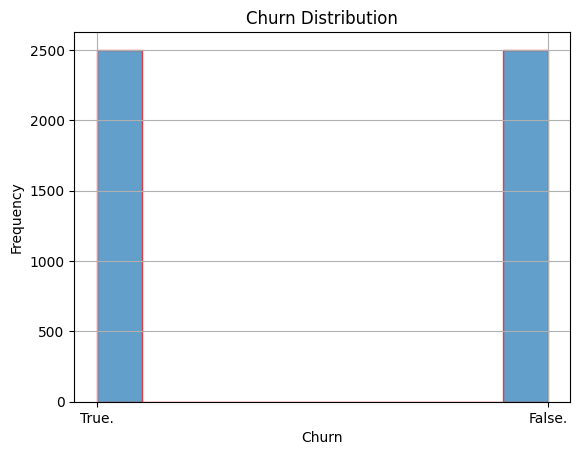

In [10]:
#creating histogram for chrun distribution
df['Churn'].hist(bins=10, edgecolor='red', alpha=0.7)
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Frequency')
plt.show()

In [11]:
x = df.drop('Churn',axis=1)
y = df['Churn']

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
num_features = ['Account_Length', 'Area_Code', 'Phone', 'Vmail_Message', 'Day_Mins', 'Day_Calls', 'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge', 'Intl_Mins','Intl_Charge', 'CustServ_Calls']
cat_features = ['State', 'Intl_Plan', 'Vmail_Plan']

In [15]:
# TRUE numeric columns only (int/float)
num_features = x_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# ALL string/object columns  
cat_features = x_train.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", num_features)
print("Categorical features:", cat_features)



Numeric features: ['Account_Length', 'Area_Code', 'Vmail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins', 'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge', 'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls']
Categorical features: ['State', 'Phone', 'Intl_Plan', 'Vmail_Plan']


In [16]:
#lets define our random forest classifier

rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1 
)

#lets create preprocessing steps and pipeline 
preprocess = ColumnTransformer([('scaler', StandardScaler(), num_features),
                               ('encode', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_features)
], remainder='passthrough'
    
)

pipeline = Pipeline([('prep', preprocess), ('rfc', rf)]).fit(x_train, y_train) 




In [17]:
#lets make our predictions
result = pipeline.predict(x_test)

In [18]:
print(classification_report(y_test, result))
print(f"Accuracy score: {accuracy_score(y_test, result):.2f}")

              precision    recall  f1-score   support

      False.       0.85      0.83      0.84       500
       True.       0.83      0.86      0.84       500

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000

Accuracy score: 0.84


In [30]:
#lets try and use cross validation on 5 folds and see if there is any improvement
cross_val = cross_val_score(pipeline, x_train, y_train, cv=5, scoring='roc_auc')
print(f"AUC ROC: {cross_val.mean():.3f}" )


AUC ROC: 0.923


In [22]:
#Retrain on FULL training data
pipeline.fit(x_train, y_train)  # Now the pipeline is trained!

# 3. Final test evaluation
y_pred = pipeline.predict(x_test)
y_pred_proba = pipeline.predict_proba(x_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC-AUC: {test_roc_auc:.3f}")

Test ROC-AUC: 0.930


In [23]:
print(classification_report(y_test, y_pred))
print(f"Accuracy score: {accuracy_score(y_test, y_pred):.2f}")

              precision    recall  f1-score   support

      False.       0.85      0.83      0.84       500
       True.       0.83      0.86      0.84       500

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000

Accuracy score: 0.84


In [31]:
#save the model
joblib.dump(pipeline, 'rf_churn_model.pickle')

['rf_churn_model.pickle']

Total features after preprocessing: 4070
Top 10 Most Important Features:
                  feature  importance
3        scaler__Day_Mins    0.122164
11   scaler__Night_Charge    0.115339
5      scaler__Day_Charge    0.101812
6        scaler__Eve_Mins    0.100683
8      scaler__Eve_Charge    0.086976
10    scaler__Night_Calls    0.075072
2   scaler__Vmail_Message    0.048847
7       scaler__Eve_Calls    0.033671
14    scaler__Intl_Charge    0.021597
9      scaler__Night_Mins    0.021511


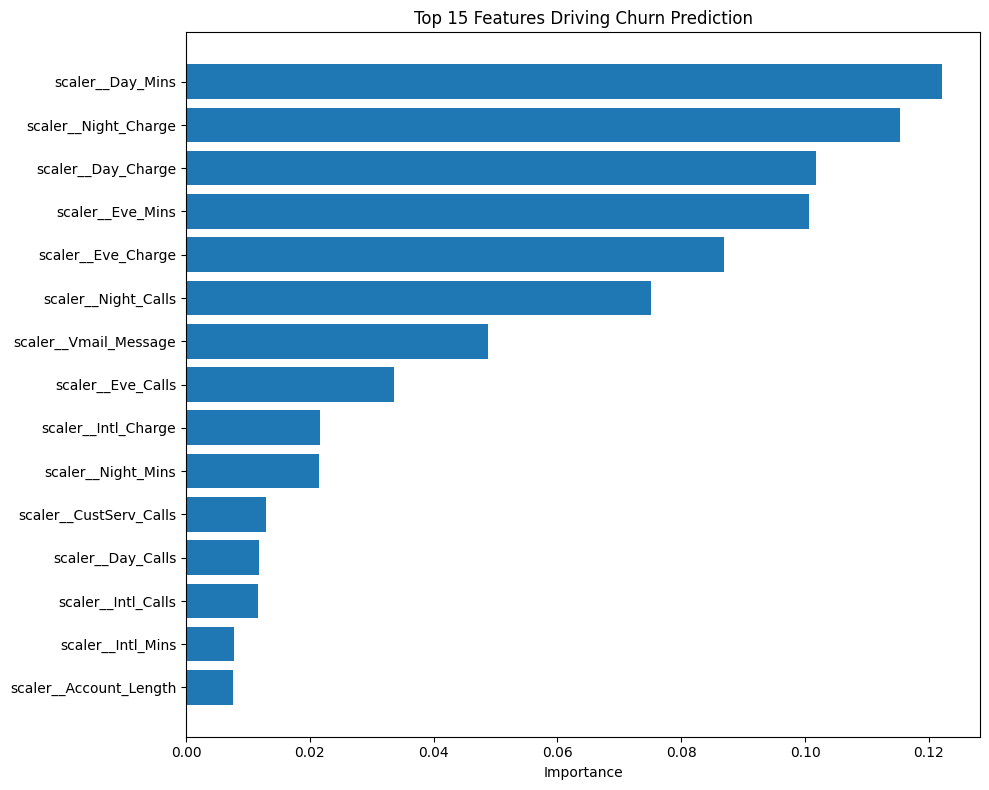

In [33]:
#feature importance from our model

# Get trained Random Forest from pipeline
rf = pipeline.named_steps['rfc']

# Get feature importances
importances = rf.feature_importances_

# Get feature names (after preprocessing)
feature_names = pipeline.named_steps['prep'].get_feature_names_out()
print("Total features after preprocessing:", len(feature_names))

# Combine importances with feature names
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))

# Plot top 15 features
top_features = feature_importance_df.head(15)
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Features Driving Churn Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()





In [40]:
#Retraining using top 7 important features to see if it can improve performance 
# 1. Get top 7 original feature names (BEFORE preprocessing)
rf = pipeline.named_steps['rfc']

# Use existing feature_importance_df instead of recreating it
importance_df = feature_importance_df.sort_values('importance', ascending=False)

# 2. Find corresponding ORIGINAL column names
top7_transformed = importance_df.head(7)['feature'].tolist()
print("Top 7 transformed features:", top7_transformed)

# 3. Map back to original columns (manual step needed)
# Look at top7_transformed output and identify original columns
# e.g., 'scaler__MonthlyIncome' → 'MonthlyIncome'

# 4. Retrain with top 7 ORIGINAL features
top7_original = ['Day_Mins', 'Night_Charge', 'Day_Charge', 'Eve_Mins', 'Eve_Charge', 'Night_Calls', 'Vmail_Message']
X_train_reduced = x_train[top7_original]
X_test_reduced = x_test[top7_original]

# Create new preprocessor for reduced features
num_features_top7 = [col for col in top7_original if col in num_features]
cat_features_top7 = [col for col in top7_original if col in cat_features]

preprocess_top7 = ColumnTransformer([
    ('scaler', StandardScaler(), num_features_top7),
    ('encode', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_features_top7)
])

pipeline_top7 = Pipeline([('prep', preprocess_top7), ('rfc', rf)])
pipeline_top7.fit(X_train_reduced, y_train)

# Get predictions for comparison
y_pred_original = y_pred  # Use existing predictions
y_pred_top7 = pipeline_top7.predict(X_test_reduced)

# 5. Compare performance
print("Original accuracy:", accuracy_score(y_test, y_pred_original))
print("Top 7 accuracy:", accuracy_score(y_test, y_pred_top7))

print("Original classification report:", classification_report(y_test, y_pred_original))
print("Top 7 classifciation report:", classification_report(y_test, y_pred_top7))

Top 7 transformed features: ['scaler__Day_Mins', 'scaler__Night_Charge', 'scaler__Day_Charge', 'scaler__Eve_Mins', 'scaler__Eve_Charge', 'scaler__Night_Calls', 'scaler__Vmail_Message']
Original accuracy: 0.842
Top 7 accuracy: 0.9
Original classification report:               precision    recall  f1-score   support

      False.       0.85      0.83      0.84       500
       True.       0.83      0.86      0.84       500

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000

Top 7 classifciation report:               precision    recall  f1-score   support

      False.       0.91      0.89      0.90       500
       True.       0.89      0.91      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



We conclude by saying the new trained model with top 7 important features has higher accuracy than the first model

In [43]:
#so lets save the new model with better accuracy.
joblib.dump(pipeline_top7, 'Top7_rf_model.pickle')

['Top7_rf_model.pickle']

In [ ]:
pip install fast api